In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
np_data = np.loadtxt("./data/Kissler_DataS1.csv", delimiter=",")
df_data = pd.DataFrame(np_data)
df_data.columns = ['Time', 'Person1', 'Person2', 'Distance']

In [37]:
# df_data[df_data['Person1'] == 60]['Person2'].value_counts()
# 411, 287, 403,  19, 26

/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


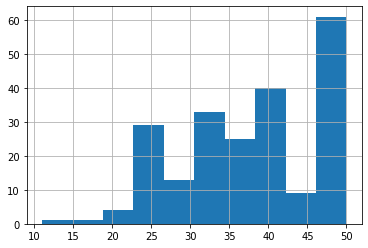

In [38]:
df_data[df_data['Person1'] == 60][df_data['Person2'] == 403]['Distance'].hist()
# df_data[df_data['Person1'] == 1][df_data['Person2'] == 287]['Distance'].hist()
# df_data[df_data['Person1'] == 1][(df_data['Person2'] != 403) & (df_data['Person2'] != 390)]['Distance'].hist()

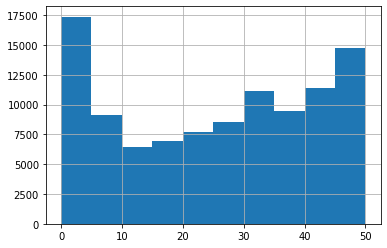

In [39]:
df_data['Distance'].hist()

# Data Augmentation

Goal: Extend 3 days of interaction data to 1 month using random sampling based on current distribution. Many current methods make it difficult to account for temporal clustering--the fact that when people initiate contact, they're likely to stay in contact (i.e. they start a conversation that lasts for a period of time).

Method: We use the existing data to create a computationally efficient Markovian model, creating separate functions to:

1. Determine the probability of nodes $i$ and $j$ being in contact at time step $t$.
2. Determine the distance between $i$ and $j$ assuming they're in contact.

## Probability

Our model mines the probability of interaction between people $i$ and $j$ from the dataset, assuming that the probability depends on whether $i$ and $j$ interacted in the previous timestep.

- If people (nodes) $i$ and $j$ are **in contact** at timestep $t$, their probability of contact at $t+1$ is 
$$
P_{ij}^{\text{stay}} = \frac{\text{# cases where $(i, j)$ were in contact at both $t$ and $t+1$}}{\text{# cases where $(i, j)$ were in contact at $t$}}
$$
- If $i$ and $j$ **aren't in contact** at $t$, their probability of contact at $t+1$ is 
$$
P_{ij}^{\text{meet}} = \frac{\text{# cases where $(i, j)$ were not in contact at $t$ but were at $t+1$}}{\text{# cases where $(i, j)$ were not in contact at $t$}}
$$

$P_{ij}^{\text{stay}}$ and $P_{ij}^{\text{meet}}$, once mined for each pair $(i,j)$, are constant throughout data generation.

## Distance

Assuming $(i,j)$ are in contact at time $t$, we now must determine their distance. If $P_{ij}^{\text{stay}} > 0.7$, our model assumes that $i$ and $j$ are "friends". Intuitively, $P_{ij}^{\text{stay}} > 0.7$ implies that whenever $i$ and $j$ interact, their expected time of interaction is $\frac{1}{1-0.7} = 3.3$ timesteps, or around 16 minutes, meaning they're likely not just passing by one another. This restriction prevents chance encounters (i.e. $i$ and $j$ are "in contact" for a single timestep because they cross each other on the street) from denoting $i$ and $j$ as "friends".

- If $i$ and $j$ are "friends", their distance during contact is drawn from a probability distribution:
$$
d_{ij}^{\text{friends}} \sim \mathcal{N}(6, 3)
$$
- If $i$ and $j$ are not "friends", their distance during contact is drawn from a different probability distribution:
$$
d_{ij}^{\text{friends}} \sim \mathcal{N}(25, 5)
$$

This sampling occurs at every time step of generation. The normal distribution parameters are determined from examining the dataset, which I will write about later. If $d_{ij}$ is sampled to be less than 0, we set it to 0.

## Generating the Data

At every timestep $t$, to determine the interaction between nodes $i$ and $j$, the following steps are therefore taken:

1. Determine the probability of interaction. If $i$ and $j$ interacted in the previous timestep, use $P_{ij}^{\text{stay}}$. Otherwise, use $P_{ij}^{\text{meet}}$.
2. Connect $i$ and $j$ with the determined probability.
3. If $i$ and $j$ are connected, sample $d_{ij}$ depending on whether $i$ and $j$ are considered "friends" or not.

Using NumPy we can vectorize operations to perform these calculations quickly.

In [40]:
def generate_more_data(df_data, more_timesteps=100):
    
    df = df_data.copy()
    
    # Generate Markovian matrices
    
    # Generate td matrix
    n = int(df['Person2'].max())
    maxtime = int(df['Time'].max())
    tdmatrix = np.zeros((maxtime, n, n))
    tdmatrix.fill(50+1) # if no edge exists, set d > xi to simulate no contact.
    df['Time'] -= 1
    df['Person1'] -= 1
    df['Person2'] -= 1
    times = df['Time'].to_numpy().astype(int)
    p1s = df['Person1'].to_numpy().astype(int)
    p2s = df['Person2'].to_numpy().astype(int)
    distances = df['Distance'].to_numpy()
    coords = np.vstack([times, p1s, p2s]).T
    for i in range(coords.shape[0]):
        coord = coords[i]
        tdmatrix[coord[0], coord[1], coord[2]] = distances[i]
        
    # Probabilities
    tdmatrix_t1 = tdmatrix[:-1] # earlier timestep
    tdmatrix_t2 = tdmatrix[1:] # later timestep
    
    prob_close_given_close = ((tdmatrix_t2 < 51) & (tdmatrix_t1 < 51)).sum(axis=0) / ((tdmatrix_t1 < 51).sum(axis=0)+0.0000001) # P(t2 close | t1 close)
    prob_close_given_far = ((tdmatrix_t2 < 51) & (tdmatrix_t1 == 51)).sum(axis=0) / ((tdmatrix_t1 == 51).sum(axis=0)+0.0000001) # P(t2 close | t1 far)
    prob_close_given_far += 0.0001
    
    # Bffl's will be closer to each other
    bffls = prob_close_given_close > 0.7
    bffl_dist, bffl_std = 6, 3
    not_bffls = np.logical_not(bffls)
    not_bffl_dist, not_bffl_std = 25, 5
    
    td0, td1, td2 = tdmatrix.shape[0], tdmatrix.shape[1], tdmatrix.shape[2]
    m = np.zeros((more_timesteps + td0, td1, td2))
    m[:tdmatrix.shape[0]] = tdmatrix
    
    for t in range(more_timesteps):
        close = m[td0+t-1] <= 50 # 1 if i,j are close, 0 otherwise
        far = np.logical_not(close) # 1 if i,j are not close, 0 otherwise
        p = np.random.random(prob_close_given_close.shape)
        p2 = np.random.random(prob_close_given_far.shape)

        bffl_d = np.maximum(0, np.random.normal(bffl_dist, bffl_std, (n, n)))
        not_bffl_d = np.maximum(0, np.random.normal(not_bffl_dist, not_bffl_std, (n, n)))
        d = bffls * bffl_d + not_bffls * not_bffl_d
        d = d.astype(int)
        
        new_dists = np.zeros((n, n))
        new_close = ((p < prob_close_given_close) * close) | ((p2 < prob_close_given_far) * far)
        new_far = np.logical_not(new_close)
        new_dists += new_close * d
        new_dists += new_far * 51.
        m[td0+t] = new_dists
        
        if t % 100 == 0:
            print(f"t: {t}. close: {close.sum()}. far: {far.sum()}")
            
        
    return m
    
moar_data = generate_more_data(df_data, 5000)
print("Done")
        
    
    

t: 0. close: 236. far: 219725
t: 100. close: 216. far: 219745
t: 200. close: 211. far: 219750
t: 300. close: 238. far: 219723
t: 400. close: 221. far: 219740
t: 500. close: 223. far: 219738
t: 600. close: 223. far: 219738
t: 700. close: 207. far: 219754
t: 800. close: 209. far: 219752
t: 900. close: 201. far: 219760
t: 1000. close: 229. far: 219732
t: 1100. close: 216. far: 219745
t: 1200. close: 215. far: 219746
t: 1300. close: 229. far: 219732
t: 1400. close: 219. far: 219742
t: 1500. close: 224. far: 219737
t: 1600. close: 232. far: 219729
t: 1700. close: 223. far: 219738
t: 1800. close: 198. far: 219763
t: 1900. close: 248. far: 219713
t: 2000. close: 208. far: 219753
t: 2100. close: 237. far: 219724
t: 2200. close: 200. far: 219761
t: 2300. close: 228. far: 219733
t: 2400. close: 234. far: 219727
t: 2500. close: 204. far: 219757
t: 2600. close: 204. far: 219757
t: 2700. close: 219. far: 219742
t: 2800. close: 226. far: 219735
t: 2900. close: 229. far: 219732
t: 3000. close: 219. f

In [41]:
coords = np.argwhere(moar_data < 51)
xd = np.where(moar_data < 51)
closedists = moar_data[xd]
print(coords.shape, closedists.shape)

(1201038, 3) (1201038,)


In [42]:
df_create = pd.DataFrame(np.hstack([coords, closedists[:,np.newaxis]]))
df_create.columns = ['Time', 'Person1', 'Person2', 'Distance']
df_create['Time'] += 1
df_create['Person1'] += 1
df_create['Person2'] += 1
df_create.head()
df_create.to_csv("data/generated_data.csv")


[18.0, 22.0, 49.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 6.0, 20.0, 0.0, 2.0, 0.0, 8.0, 31.0]


/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(0, 50)

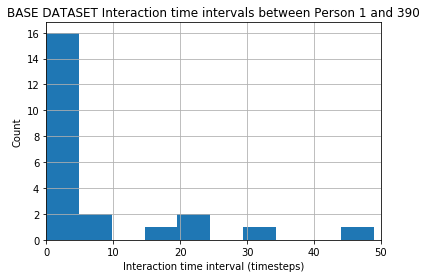

In [43]:
points = list(df_create[df_create['Person1']==1][df_create['Person2']==390][df_create['Time']<573]['Time'])
intervals = []
startpt = points[0]
endpt = -1
for i in range(len(points)-1):
    if points[i]+1 == points[i+1]:
        pass
    else:
        endpt = points[i]
        intervals.append((startpt, endpt))
        startpt = points[i+1]


ilens = [x[1]-x[0] for x in intervals]
print(ilens)
pd.Series(ilens).hist()
plt.title("BASE DATASET Interaction time intervals between Person 1 and 390")
plt.xlabel("Interaction time interval (timesteps)")
plt.ylabel("Count")
plt.xlim(0, 50)

/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


[4.0, 10.0, 2.0, 3.0, 15.0, 1.0, 5.0, 12.0, 0.0, 2.0, 5.0, 0.0, 21.0, 20.0, 0.0, 28.0, 11.0, 5.0, 13.0, 8.0, 14.0, 10.0, 6.0, 5.0, 12.0, 6.0, 20.0, 2.0, 5.0, 4.0, 7.0, 34.0, 1.0, 2.0, 4.0, 11.0, 7.0, 25.0, 11.0, 9.0, 3.0, 2.0, 4.0, 3.0, 6.0, 0.0, 1.0, 1.0, 16.0, 0.0, 21.0, 0.0, 2.0, 6.0, 0.0, 1.0, 9.0, 4.0, 8.0, 1.0, 1.0, 1.0, 2.0, 6.0, 7.0, 26.0, 5.0, 5.0, 13.0, 15.0, 5.0, 3.0, 11.0, 0.0, 16.0, 31.0, 2.0, 1.0, 6.0, 7.0, 2.0, 2.0, 2.0, 3.0, 25.0, 28.0, 1.0, 5.0, 0.0, 1.0, 1.0, 5.0, 4.0, 25.0, 9.0, 2.0, 1.0, 7.0, 17.0, 29.0, 11.0, 20.0, 26.0, 18.0, 17.0, 0.0, 22.0, 2.0, 8.0, 0.0, 18.0, 14.0, 6.0, 17.0, 3.0, 9.0, 3.0, 0.0, 20.0, 2.0, 11.0, 18.0, 20.0, 1.0, 26.0, 16.0, 1.0, 0.0, 2.0, 0.0, 1.0, 4.0, 6.0, 6.0, 13.0, 10.0, 8.0, 11.0, 5.0, 0.0, 23.0, 14.0, 5.0, 27.0, 10.0, 21.0, 7.0, 16.0, 7.0, 6.0, 15.0, 12.0, 12.0, 13.0, 18.0, 7.0, 1.0, 10.0, 18.0, 9.0, 5.0, 0.0, 0.0, 4.0, 21.0, 1.0, 10.0, 6.0, 4.0, 12.0, 1.0, 2.0, 9.0, 0.0]


(0, 50)

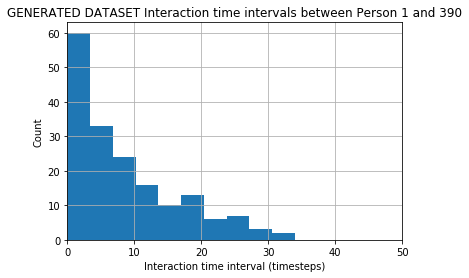

In [44]:
points = list(df_create[df_create['Person1']==1][df_create['Person2']==390][df_create['Time']>=573]['Time'])
intervals = []
startpt = points[0]
endpt = -1
for i in range(len(points)-1):
    if points[i]+1 == points[i+1]:
        pass
    else:
        endpt = points[i]
        intervals.append((startpt, endpt))
        startpt = points[i+1]

ilens = [x[1]-x[0] for x in intervals]
print(ilens)
pd.Series(ilens).hist()

plt.title("GENERATED DATASET Interaction time intervals between Person 1 and 390")
plt.xlabel("Interaction time interval (timesteps)")
plt.ylabel("Count")
plt.xlim(0, 50)

[18.0, 22.0, 49.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 6.0, 20.0, 0.0, 2.0, 0.0, 8.0, 31.0]


/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(0, 50)

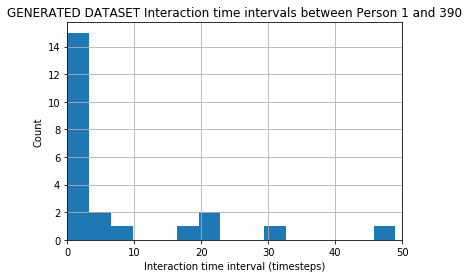

In [55]:
points = list(df_create[df_create['Person1']==1][df_create['Person2']==390][df_create['Time']<573]['Time'])
intervals = []
startpt = points[0]
endpt = -1
for i in range(len(points)-1):
    if points[i]+1 == points[i+1]:
        pass
    else:
        endpt = points[i]
        intervals.append((startpt, endpt))
        startpt = points[i+1]

ilens = [x[1]-x[0] for x in intervals]
print(ilens)
pd.Series(ilens).hist(bins=15)

plt.title("GENERATED DATASET Interaction time intervals between Person 1 and 390")
plt.xlabel("Interaction time interval (timesteps)")
plt.ylabel("Count")
plt.xlim(0, 50)

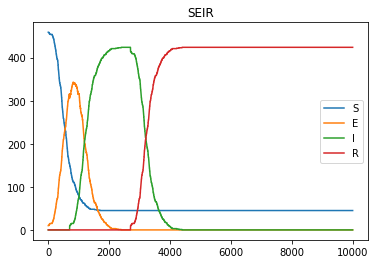

In [106]:
from seir_simulator import *


sim = SEIR_Simulator(df_create)
# sim.infect_k_random(10)
sim.set_k_random(10, State.E)
results = sim.simulate(timesteps=10000, logsteps=False)
plot_SEIR(*results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(0, 50)

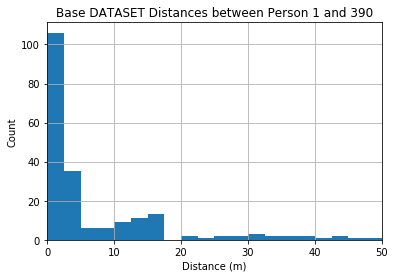

In [48]:
distances = df_create[df_create['Person1']==1][df_create['Person2']==390][df_create['Time']<573]['Distance']
distances.hist(bins=20)
plt.title("Base DATASET Distances between Person 1 and 390")
plt.xlabel("Distance (m)")
plt.ylabel("Count")
plt.xlim(0, 50)

/Users/maxwu/miniconda3/envs/ganimals/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(0, 50)

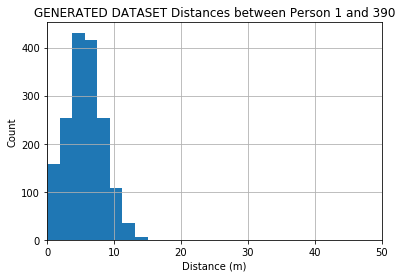

In [52]:
distances = df_create[df_create['Person1']==1][df_create['Person2']==390][df_create['Time']>=573]['Distance']
distances.hist(bins=8)
plt.title("GENERATED DATASET Distances between Person 1 and 390")
plt.xlabel("Distance (m)")
plt.ylabel("Count")
plt.xlim(0, 50)